In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import preprocessing


In [2]:
df = pd.read_csv('Salary Data.csv')
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [3]:
# Checking for null values.
df.isnull().sum()

Age                    2
Gender                 2
Education Level        2
Job Title              2
Years of Experience    2
Salary                 2
dtype: int64

In [4]:
# Deleting null values
df.dropna(inplace=True)
df.isnull().sum()

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

In [5]:
# Checking for duplicate values
df.duplicated().sum()

np.int64(49)

In [6]:
# Deleting duplicate values
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [7]:
#Inter-Quartile-Range
def remove_outliers_iqr(df, column, group_by):
    cleaned_df = pd.DataFrame()
    for group in df[group_by].unique():
        subset = df[df[group_by] == group]
        Q1 = subset[column].quantile(0.25)
        Q3 = subset[column].quantile(0.75)
        IQR = Q3 - Q1
        filtered = subset[(subset[column] >= Q1 - 1.5 * IQR) & 
                          (subset[column] <= Q3 + 1.5 * IQR)]
        cleaned_df = pd.concat([cleaned_df, filtered])
    return cleaned_df.reset_index(drop=True)

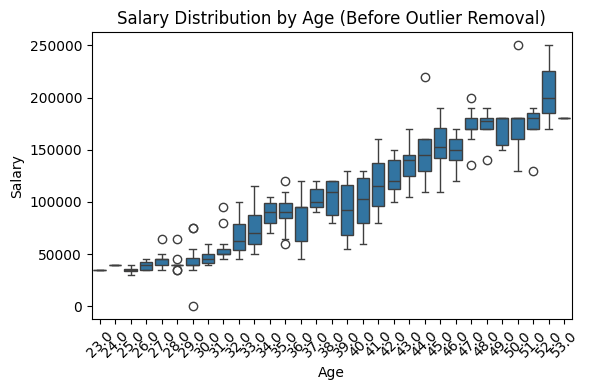

In [8]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Age', y='Salary', data=df)
plt.title("Salary Distribution by Age (Before Outlier Removal)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
df_cleaned = remove_outliers_iqr(df, column='Salary', group_by='Age')

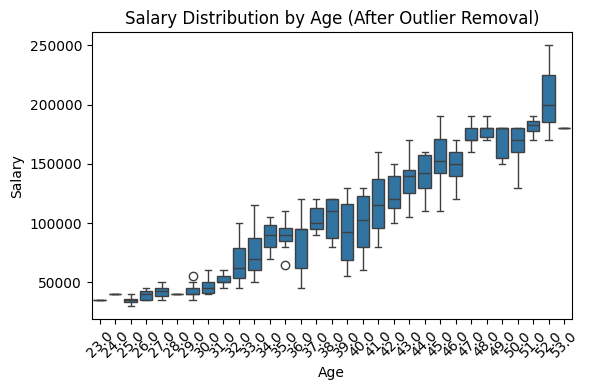

In [10]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Age', y='Salary', data=df_cleaned)
plt.title("Salary Distribution by Age (After Outlier Removal)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

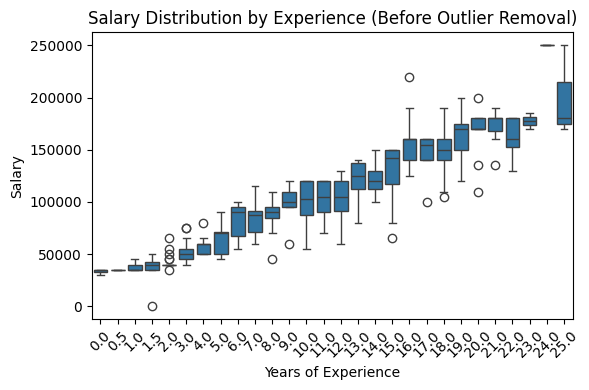

In [11]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Years of Experience', y='Salary', data=df)
plt.title("Salary Distribution by Experience (Before Outlier Removal)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
df_cleaned = remove_outliers_iqr(df, column='Salary', group_by='Years of Experience')

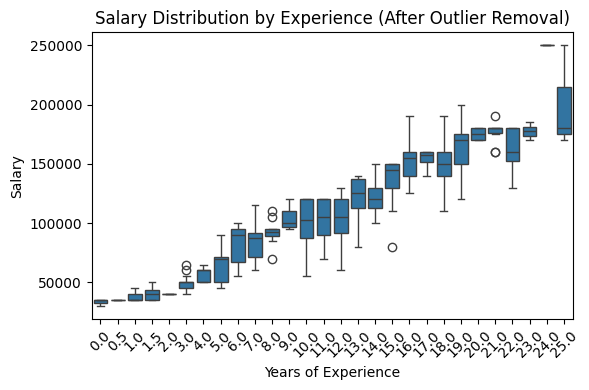

In [13]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Years of Experience', y='Salary', data=df_cleaned)
plt.title("Salary Distribution by Experience (After Outlier Removal)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Label Encoding on Gender and Job Title 
le_gender = LabelEncoder()
le_job = LabelEncoder()

le_gender = LabelEncoder()
df_cleaned['Gender'] = le_gender.fit_transform(df_cleaned['Gender'])

le_job = LabelEncoder()
df_cleaned['Job Title'] = le_job.fit_transform(df_cleaned['Job Title'])

In [15]:
# Split Features and Target
X = df_cleaned.drop('Salary', axis=1)
y = df_cleaned['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90)


In [16]:
# One-hot Encoding on Education Level
X_train = pd.get_dummies(X_train, columns=['Education Level'], drop_first=False)
X_test = pd.get_dummies(X_test, columns=['Education Level'], drop_first=False)

# Align test set columns with training set 
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [ ]:
# Training Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

In [ ]:
#Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = rf_model.score(X_test, y_test) * 100
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Mean Squared Error:", mse)
print("R² Score:", r2)
print(f"Model Accuracy: {accuracy:.2f}%")  
print(f"MAPE: {mape:.2f}%") 

Mean Squared Error: 120199309.83606558
R² Score: 0.9428448856416285
Model Accuracy: 94.28%
MAPE: 7.73%


In [ ]:
# # Save model, encoders, and expected columns
# joblib.dump(rf_model, 'rf_model.joblib')
# joblib.dump(le_gender, 'le_gender_encoder.joblib')
# joblib.dump(le_job, 'le_job_encoder.joblib')
# joblib.dump(X_train.columns.tolist(), 'expected_columns.joblib')
# metrics = {
#     "MSE": mse,
#     "R2_Score": r2,
#     "Accuracy (%)": accuracy,
#     "MAPE (%)": mape
# }

# # Save to joblib
# joblib.dump(metrics, "saved files/model_metrics.joblib")

['saved files/model_metrics.joblib']

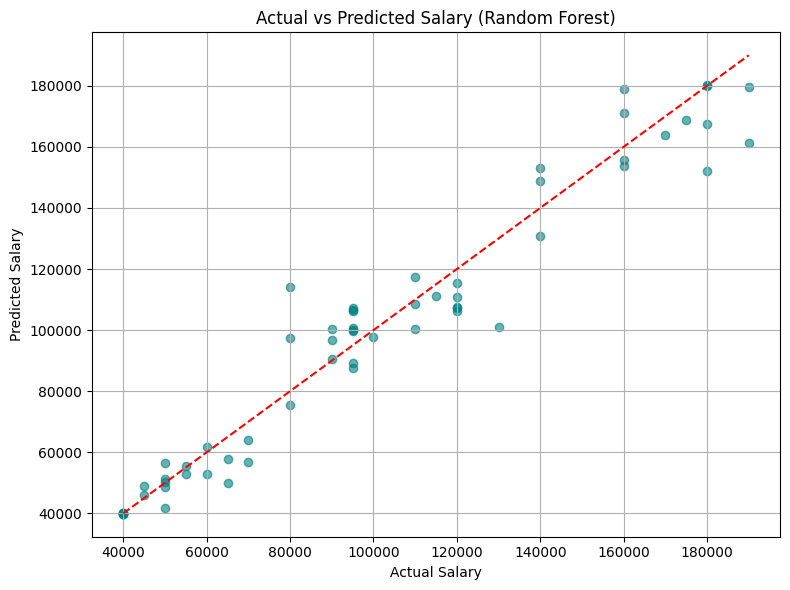

In [ ]:
# Actual vs Predicted Graph
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.grid(True)
plt.tight_layout()
plt.show()

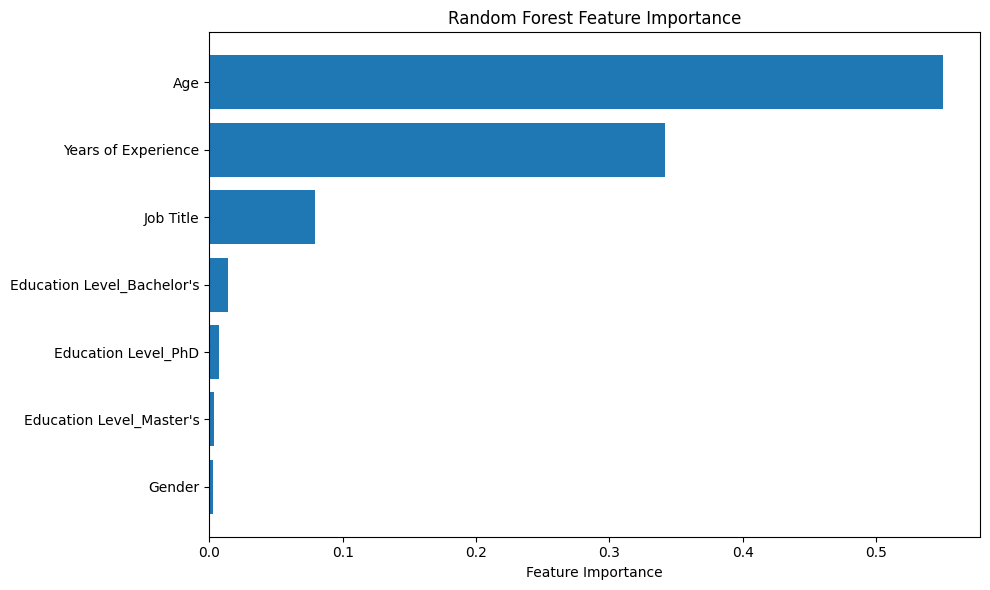

In [21]:
importances = rf_model.feature_importances_
features = X_train.columns

# Sort features by importance
indices = np.argsort(importances)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), [features[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()